# Classification de la Qualité des Diamants 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.tree import DecisionTreeClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

## Chargement et Nettoyage

In [ ]:
df = pd.read_csv("../data/diamonds_dataset.csv") # Assurez-vous que le chemin est bon

# Nettoyage des noms de colonnes
df.columns = df.columns.str.replace(' ', '_').str.replace('%', 'pct').str.replace('/', '_per_')

# --- 1. Définition des Maps ---
cut_map = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4, 'Excellent': 4} 
grade_map = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Very Good': 3, 'Excellent': 4}
fluo_map = {'None': 0, 'Faint': 1, 'Medium': 2, 'Strong': 3, 'Very Strong': 4}
color_map = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}
clarity_map = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
type_map = {'GIA Lab-Grown' : 0, 'GIA' : 1, 'IGI Lab-Grown' : 2}

# --- 2. Application des Maps (Gestion intelligente des vides) ---

# Pour 'Cut' : Il manque trop de données (4300+), on supprime la colonne pour sauver les lignes
df = df.drop(columns=['Cut']) 

# Pour 'Fluorescence' : On remplace les vides par 0 (None)
df['Fluorescence'] = df['Fluorescence'].map(fluo_map).fillna(0)

# Pour les autres : On applique les maps normalement
df['Polish'] = df['Polish'].map(grade_map)
df['Symmetry'] = df['Symmetry'].map(grade_map)
df['Color'] = df['Color'].map(color_map)
df['Clarity'] = df['Clarity'].map(clarity_map)
df['Type'] = df['Type'].map(type_map)

# --- 3. Encodage des variables catégorielles restantes ---
# On enlève 'Culet' car il est presque vide aussi (4500+ manquants)
cols_to_dummy = ['Shape', 'Girdle'] 
df = df.drop(columns=['Culet']) # On supprime Culet explicitement
df = pd.get_dummies(df, columns=cols_to_dummy, drop_first=True)

# --- 4. Nettoyage final ---
# Maintenant on peut faire dropna, car il ne supprimera que quelques lignes (pas 6000 !)
df.dropna(inplace=True)

print(f"Lignes restantes : {len(df)}")
print("Distribution des types :")
print(df['Type'].value_counts())

Lignes restantes : 6459
Distribution des types :
Type
1    3340
2    1871
0    1248
Name: count, dtype: int64


In [3]:
df.columns

Index(['Color', 'Clarity', 'Carat_Weight', 'Length_per_Width_Ratio',
       'Depth_pct', 'Table_pct', 'Polish', 'Symmetry', 'Length', 'Width',
       'Height', 'Price', 'Type', 'Fluorescence', 'Shape_Cushion Modified',
       'Shape_Emerald', 'Shape_Heart', 'Shape_Marquise', 'Shape_Oval',
       'Shape_Pear', 'Shape_Princess', 'Shape_Radiant', 'Shape_Round',
       'Shape_Square Radiant', 'Girdle_Extremely Thin to Extremely Thick',
       'Girdle_Extremely Thin to Medium',
       'Girdle_Extremely Thin to Slightly Thick', 'Girdle_Medium',
       'Girdle_Medium to Extremely Thick', 'Girdle_Medium to Slightly Thick',
       'Girdle_Medium to Thick', 'Girdle_Medium to Very Thick',
       'Girdle_Slightly Thick', 'Girdle_Slightly Thick to Extremely Thick',
       'Girdle_Slightly Thick to Slightly Thick',
       'Girdle_Slightly Thick to Thick', 'Girdle_Slightly Thick to Very Thick',
       'Girdle_Thick', 'Girdle_Thick to Extremely Thick',
       'Girdle_Thick to Very Thick', 'Girdle_Thin

## Feature Engineering 

In [4]:
df['volume'] = df['Length'] * df['Width'] * df['Height']
df['volume'] = df['volume'].replace(0, 0.01) 

df['table_depth_ratio'] = df['Table_pct'] / df['Depth_pct']

df['lw_ratio'] = df['Length'] / (df['Width'] + 0.001)

## Info

In [5]:
df.shape

(6459, 55)

In [6]:
df.describe()

,Color,Clarity,Carat_Weight,Length_per_Width_Ratio,Depth_pct,Table_pct,Polish,Symmetry,Length,Width,Height,Price,Type,Fluorescence,volume,table_depth_ratio,lw_ratio
count,6459.000000,6459.000000,6459.000000,6459.000000,6459.000000,6459.000000,6459.000000,6459.000000,6459.000000,6459.000000,6459.000000,6459.000000,6459.000000,6459.000000,6459.000000,6459.000000,6459.000000
mean,4.377458,4.165660,1.234668,1.328941,64.209862,61.828921,3.913299,3.685091,7.660212,6.098638,3.886012,3515.295402,1.096455,0.302833,185.839005,0.964615,1.292689
std,1.429664,0.938224,0.505707,0.325022,4.773718,4.760605,0.299542,0.504160,1.669292,1.151567,0.599553,3240.428255,0.688231,0.711327,89.591461,0.059756,0.356565
min,2.000000,3.000000,1.000000,1.000000,46.100000,51.000000,2.000000,2.000000,5.180000,4.420000,2.670000,1010.000000,0.000000,0.000000,93.944448,0.748960,0.782014
25%,3.000000,4.000000,1.010000,1.020000,61.200000,58.000000,4.000000,3.000000,6.330000,5.390000,3.460000,1210.000000,1.000000,0.000000,130.607766,0.926756,0.997187
50%,5.000000,4.000000,1.030000,1.270000,63.100000,61.000000,4.000000,4.000000,7.420000,5.640000,3.670000,3310.000000,1.000000,0.000000,167.469120,0.959119,1.267467
75%,6.000000,5.000000,1.190000,1.510000,67.600000,65.000000,4.000000,4.000000,8.640000,6.610000,4.100000,4380.000000,2.000000,0.000000,193.616798,0.993953,1.511040
max,6.000000,7.000000,9.380000,2.580000,77.000000,78.000000,4.000000,4.000000,15.210000,14.880000,8.170000,39460.000000,2.000000,3.000000,1615.659984,1.344902,2.583843


In [7]:
df.head()

,Color,Clarity,Carat_Weight,Length_per_Width_Ratio,Depth_pct,Table_pct,Polish,Symmetry,Length,Width,...,Girdle_Thin to Very Thick,Girdle_Very Thick,Girdle_Very Thick to Extremely Thick,Girdle_Very Thin to Extremely Thick,Girdle_Very Thin to Slightly Thick,Girdle_Very Thin to Thick,Girdle_Very Thin to Very Thick,volume,table_depth_ratio,lw_ratio
0,4.0,5.0,1.84,1.02,65.8,59.0,4.0,3.0,7.09,6.95,...,False,False,False,False,False,False,False,225.189035,0.896657,1.019997
1,5.0,4.0,1.20,1.65,62.5,58.0,3.0,3.0,9.64,5.86,...,False,False,False,False,False,False,False,206.754864,0.928000,1.644771
2,5.0,4.0,1.19,1.41,63.1,63.0,3.0,3.0,8.44,6.00,...,False,False,False,False,False,False,False,191.925600,0.998415,1.406432
3,6.0,7.0,1.00,1.18,61.7,58.0,4.0,4.0,5.85,6.89,...,False,False,False,False,False,False,False,171.302625,0.940032,0.848933
4,2.0,4.0,1.01,1.35,69.4,66.0,4.0,3.0,6.80,5.05,...,False,False,False,False,False,False,False,120.190000,0.951009,1.346268


## Préparation des données 

In [9]:
target = 'Type'
X = df.drop(columns=[target, "Price"])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)


## Modèle Decision Tree

In [10]:
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train, y_train)

y_pred_train = tree_classifier.predict(X_train)
y_pred_test = tree_classifier.predict(X_test)

importance = tree_classifier.feature_importances_

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy train : {accuracy_train:.2f}")
print(f"Accuracy test: {accuracy_test:.2f}")

Accuracy train : 1.00
Accuracy test: 0.91


In [11]:
print("Ce que le modèle prédit :")
print(pd.Series(y_pred_test).value_counts())

Ce que le modèle prédit :
1    659
2    381
0    252
Name: count, dtype: int64


In [12]:
print("Ce qu'il y a vraiment dans le test :")
print(y_test.value_counts())

Ce qu'il y a vraiment dans le test :
Type
1    668
2    374
0    250
Name: count, dtype: int64


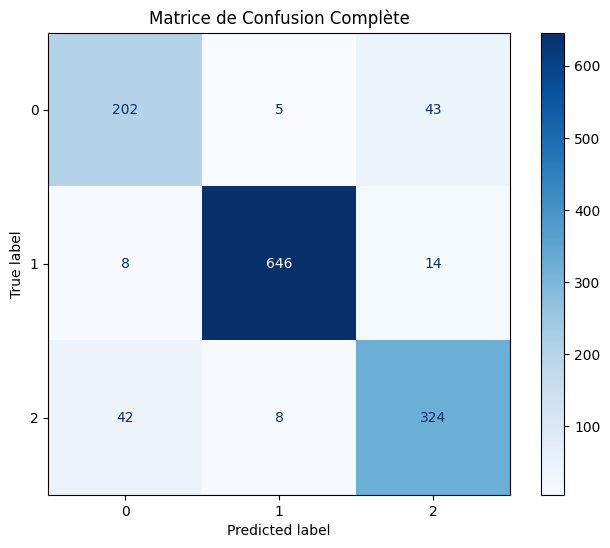

In [13]:
all_classes = tree_classifier.classes_

fig, ax = plt.subplots(figsize=(8, 6))

ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_test, 
    labels=all_classes,      # <--- C'est la ligne magique qui force toutes les classes
    display_labels=all_classes, # Pour avoir les bons noms sur les axes
    cmap=plt.cm.Blues,
    ax=ax
)

ax.set_title("Matrice de Confusion Complète")
plt.show()

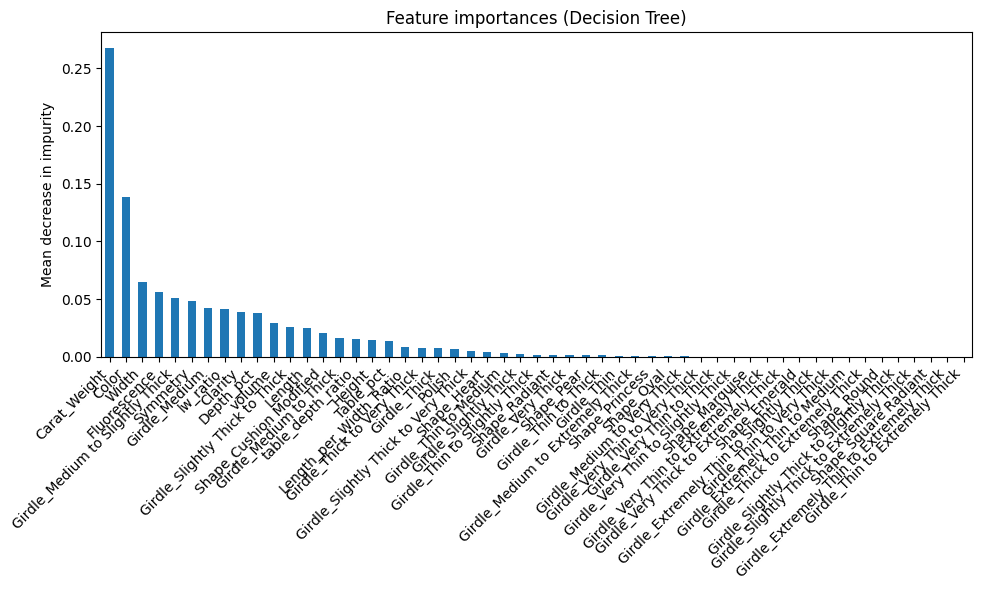

In [14]:
feature_names = X.columns 
forest_importances = pd.Series(importance, index=feature_names)
fig, ax = plt.subplots(figsize=(10, 6))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax) 
ax.set_title("Feature importances (Decision Tree)")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=45, ha='right') 
fig.tight_layout()
plt.show()

## Modèle TensorFlow

In [15]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(3, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

model.summary()

c:\Users\lepot\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,963 (222.51 KB)

 Trainable params: 56,067 (219.01 KB)

 Non-trainable params: 896 (3.50 KB)

## Entraînement

In [16]:
classes_uniques = np.unique(y_train)
poids = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes_uniques,
    y=y_train
)
poids_dict = dict(zip(classes_uniques, poids))

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train_scaled, 
    y_train_cat, 
    epochs=50, 
    batch_size=64, 
    validation_data=(X_test_scaled, y_test_cat),
    callbacks=[early_stopping, lr_scheduler],
    class_weight=poids_dict,
    verbose=1
)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7362 - loss: 0.6988 - precision: 0.7650 - recall: 0.7070 - val_accuracy: 0.8723 - val_loss: 0.4231 - val_precision: 0.9268 - val_recall: 0.7941 - learning_rate: 0.0010
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8504 - loss: 0.4497 - precision: 0.8667 - recall: 0.8330 - val_accuracy: 0.9040 - val_loss: 0.2866 - val_precision: 0.9202 - val_recall: 0.8924 - learning_rate: 0.0010
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8692 - loss: 0.3948 - precision: 0.8794 - recall: 0.8595 - val_accuracy: 0.9033 - val_loss: 0.2595 - val_precision: 0.9089 - val_recall: 0.8963 - learning_rate: 0.0010
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8848 - loss: 0.3516 - precision: 0.8929 - recall: 0.8781 - val_accuracy: 0.8986 - val_loss: 0.2414 - val_precision: 0.9030 - val_recall: 0.8940 - learning_rate: 0.0010
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8941 - l

## Évaluation et Résultats

Test Accuracy : 0.9365
Test Precision: 0.9373
Test Recall   : 0.9365
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Figure size 1000x800 with 0 Axes>

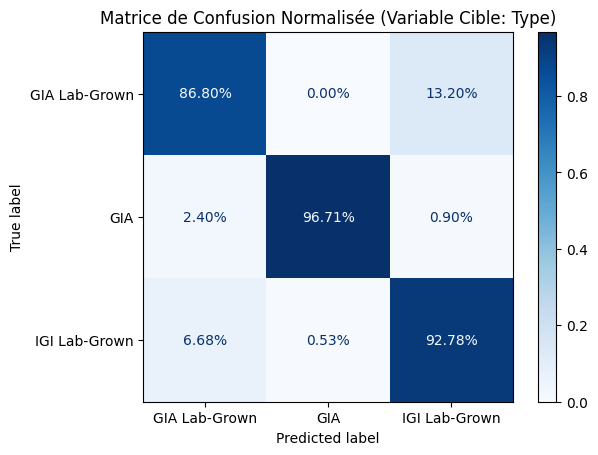

In [17]:
loss, acc, prec, rec = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"Test Accuracy : {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall   : {rec:.4f}")

y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')
correct_labels = ['GIA Lab-Grown', 'GIA', 'IGI Lab-Grown']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=correct_labels)
disp.plot(cmap='Blues', values_format='.2%')
plt.title("Matrice de Confusion Normalisée (Variable Cible: Type)")
plt.show()